<a href="https://colab.research.google.com/github/pcdanh/CS2225.CH1501/blob/master/phanloailua_Danh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers



In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/pcdanh/CS2225.CH1501/master/data.zip \
    -O /tmp/data.zip

--2020-09-17 10:52:53--  https://raw.githubusercontent.com/pcdanh/CS2225.CH1501/master/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7763825 (7.4M) [application/zip]
Saving to: ‘/tmp/data.zip’

/tmp/data.zip       100%[===================>]   7.40M  20.0MB/s    in 0.4s    

2020-09-17 10:52:53 (20.0 MB/s) - ‘/tmp/data.zip’ saved [7763825/7763825]



In [ ]:
import zipfile

local_zip = '/tmp/data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
data_dir = '/tmp/lua'
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')



In [ ]:
module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)


BATCH_SIZE = 64 

In [ ]:
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True 
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 84 images belonging to 3 classes.
Found 157 images belonging to 3 classes.


In [ ]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])

In [ ]:
do_fine_tuning = False
if do_fine_tuning:
  feature_extractor.trainable = True
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False

In [ ]:
print("Xây dựng model với", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.summary()

Xây dựng model với https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 22,853,411
Trainable params: 1,050,627
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
LEARNING_RATE = 0.001 #@param {type:"number"}
model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [ ]:
EPOCHS=10

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/10
2/2 [==============================] - 29s 15s/step - loss: 2.4561 - accuracy: 0.4946 - val_loss: 3.0831 - val_accuracy: 0.6719
Epoch 2/10
2/2 [==============================] - 27s 13s/step - loss: 1.7286 - accuracy: 0.6250 - val_loss: 1.3236 - val_accuracy: 0.5469
Epoch 3/10
2/2 [==============================] - 27s 14s/step - loss: 0.8159 - accuracy: 0.6774 - val_loss: 1.7267 - val_accuracy: 0.2656
Epoch 4/10
2/2 [==============================] - 27s 14s/step - loss: 0.7193 - accuracy: 0.7312 - val_loss: 1.0094 - val_accuracy: 0.6250
Epoch 5/10
2/2 [==============================] - 26s 13s/step - loss: 0.4175 - accuracy: 0.7891 - val_loss: 1.1452 - val_accuracy: 0.6562
Epoch 6/10
2/2 [==============================] - 26s 13s/step - loss: 0.5738 - accuracy: 0.7891 - val_loss: 1.0412 - val_accuracy: 0.6562
Epoch 7/10
2/2 [==============================] - 28s 14s/step - loss: 0.4408 - accuracy: 0.8281 - val_loss: 0.8383 - val_accuracy: 0.7500
Epoch 8/10
2/2 [===========

Đánh giá

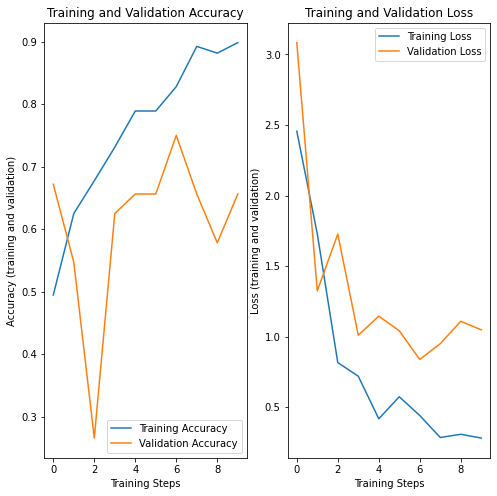

In [ ]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [ ]:
!!wget https://raw.githubusercontent.com/pcdanh/CS2225.CH1501/master/data.zip
!unzip data.zip;

Archive:  data.zip
replace lua/tenbenh.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: lua/tenbenh.json        
  inflating: lua/train/bacterial_leaf_blight/blight_rotated_044.jpg  
  inflating: lua/train/bacterial_leaf_blight/blight_rotated_045.jpg  
  inflating: lua/train/bacterial_leaf_blight/blight_rotated_046.jpg  
  inflating: lua/train/bacterial_leaf_blight/blight_rotated_047.jpg  
  inflating: lua/train/bacterial_leaf_blight/blight_rotated_048.jpg  
  inflating: lua/train/bacterial_leaf_blight/blight_rotated_049.jpg  
  inflating: lua/train/bacterial_leaf_blight/blight_rotated_050.jpg  
  inflating: lua/train/bacterial_leaf_blight/blight_rotated_051.jpg  
  inflating: lua/train/bacterial_leaf_blight/blight_rotated_052.jpg  
  inflating: lua/train/bacterial_leaf_blight/blight_rotated_053.jpg  
  inflating: lua/train/bacterial_leaf_blight/blight_rotated_054.jpg  
  inflating: lua/train/bacterial_leaf_blight/blight_rotated_055.jpg  
  inflating: lua/train/bacterial_leaf

In [ ]:
import json

with open('lua/tenbenh.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
print (classes)

['Bệnh bạc lá', 'Bệnh Đạo Ôn', 'Bệnh đốm nâu']


SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_040.jpg
PREDICTED: class: Bệnh bạc lá, confidence: 0.541694


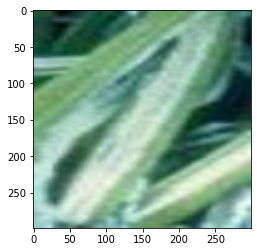

<Figure size 432x288 with 0 Axes>

SOURCE: class: brownspot, file: brownspot/brownspot_rotated_010.jpg
PREDICTED: class: Bệnh bạc lá, confidence: 0.975272


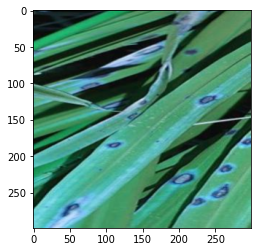

SOURCE: class: blast, file: blast/blast_rotated_016.png
PREDICTED: class: Bệnh Đạo Ôn, confidence: 0.804697


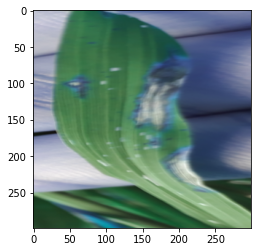

<Figure size 432x288 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_012.png
PREDICTED: class: Bệnh bạc lá, confidence: 0.508528


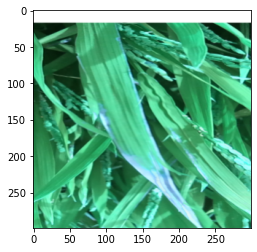

<Figure size 432x288 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_009.JPG
PREDICTED: class: Bệnh Đạo Ôn, confidence: 0.505789


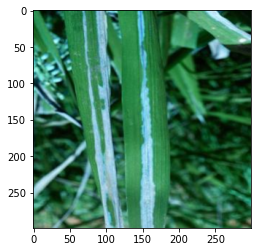

<Figure size 432x288 with 0 Axes>

In [ ]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}


for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)